In [5]:
# We complexify the previoius model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [1]:
# read in all the words
words = open('nomi_italiani.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

9118
27
['abaco', 'abbondanza', 'abbondanzia', 'abbondanzio', 'abbondazio', 'abbondia', 'abbondina', 'abbondio']


In [2]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: "'", 3: ',', 0: '.', 5: 'a', 6: 'b', 7: 'c', 8: 'd', 9: 'e', 10: 'f', 11: 'g', 12: 'h', 13: 'i', 14: 'j', 15: 'k', 16: 'l', 17: 'm', 18: 'n', 19: 'o', 20: 'p', 21: 'q', 22: 'r', 23: 's', 24: 't', 25: 'u', 26: 'v', 27: 'w', 28: 'x', 29: 'y', 30: 'z', 31: 'Ë', 32: 'Ï', 33: 'Ú', 34: '˘', 35: '‡'}
35


In [3]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
block_size = 8  # context length: how many characters do we take to predict the next one?


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte = build_dataset(words[n2:])     # 10%

torch.Size([59036, 8]) torch.Size([59036])
torch.Size([7295, 8]) torch.Size([7295])
torch.Size([7410, 8]) torch.Size([7410])


In [7]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / \
            fan_in**0.5  # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)) 

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n ):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n , C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [8]:
n_embd = 32
n_hidden = 64



layers = [
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    Tanh(),
    FlattenConsecutive(2), 
    Linear(n_hidden * 2, n_hidden, bias = False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size) 
]
model = Sequential(layers)

with torch.no_grad():
    layers[-1].weight *= 0.1  # make less confident

parameters = [p for l in layers for p in l.parameters()]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

24259


In [43]:
max_steps = 300000
batch_size = 64
lossi = []

for i in range(max_steps):

    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    x = model(Xb)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update, stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01
    #lr = 0.01
    with torch.no_grad():
        for p in parameters:
            p.data -= lr * p.grad
    if i % 1000 == 0: 
        print(f'Iteration: {i:7d}/{max_steps} ||| Learning rate = {lr} ||| Loss = {loss.item():.4f}') 
    lossi.append(loss.log10().item())


Iteration:       0/300000 ||| Learning rate = 0.1 ||| Loss = 3.3044
Iteration:    1000/300000 ||| Learning rate = 0.1 ||| Loss = 2.2510
Iteration:    2000/300000 ||| Learning rate = 0.1 ||| Loss = 2.4040
Iteration:    3000/300000 ||| Learning rate = 0.1 ||| Loss = 2.3610
Iteration:    4000/300000 ||| Learning rate = 0.1 ||| Loss = 2.0795
Iteration:    5000/300000 ||| Learning rate = 0.1 ||| Loss = 2.3136
Iteration:    6000/300000 ||| Learning rate = 0.1 ||| Loss = 2.1587
Iteration:    7000/300000 ||| Learning rate = 0.1 ||| Loss = 2.2759
Iteration:    8000/300000 ||| Learning rate = 0.1 ||| Loss = 2.6820
Iteration:    9000/300000 ||| Learning rate = 0.1 ||| Loss = 2.4231
Iteration:   10000/300000 ||| Learning rate = 0.1 ||| Loss = 2.1965
Iteration:   11000/300000 ||| Learning rate = 0.1 ||| Loss = 2.4040
Iteration:   12000/300000 ||| Learning rate = 0.1 ||| Loss = 2.1528
Iteration:   13000/300000 ||| Learning rate = 0.1 ||| Loss = 2.3111
Iteration:   14000/300000 ||| Learning rate = 0.

KeyboardInterrupt: 

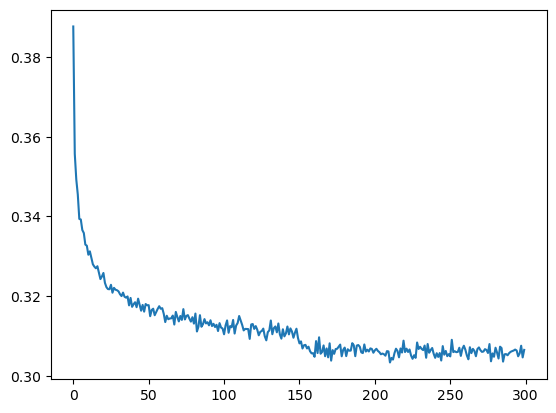

In [35]:
#lossi = torch.tensor(lossi)
#lossi = lossi.view((-1, 1000)).mean(dim=1)
plt.plot(torch.tensor(lossi).view((-1, 1000)).mean(dim=1))

In [39]:
for layer in layers:
    layer.training = False

In [40]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    x = model(x)
    loss = F.cross_entropy(x, y)
    

    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.009455919265747
val 2.070033550262451


In [41]:
def sample(num_samples=20):
    samples = []
    for i in range(num_samples):
        out = []
        context = [0] * block_size
        while True:
            x = torch.tensor(context[-block_size:]).unsqueeze(0)
            x = model(x)
            x = x.squeeze()
            x = F.softmax(x, dim=-1)
            x = torch.multinomial(x, 1).item()
            if x == 0:
                break
            out.append(itos[x])
            context = context[1:] + [x]
        samples.append(''.join(out))
    return samples

sample = sample()
for s in sample:
    if s not in words:
        print(s)

aqnelle
saz
estoory
dalyk
deliybel
jamurah
elequadu
kambers
mankiel
aary
nario
humir
roxyn
nikai
abbielle
jaxtwer
anaina
